In [10]:
import hoomd
import hoomd.hpmc
import ex_render
from matplotlib import pyplot
import numpy
import sys
%matplotlib inline

# Quick compression scheme

You can compress a system from a random dilute configuration to a high packing fraction quickly. The trick is to force the system volume to compress. This generates small overlaps between the particles. Then perform trial moves until all of the overlaps are gone. Repeat this process until it reaches the desired packing fraction.

## Random trial configuration

First, prepare a random initial configuration. Start from a hexagonal lattice at low denstiy and perform some MC trial moves.

In [2]:
hoomd.context.initialize('--mode=cpu')
system = hoomd.init.create_lattice(unitcell=hoomd.lattice.hex(a=1.2), n=[10, 6])
initial_Ly = system.box.Ly
mc = hoomd.hpmc.integrate.convex_polygon(d=0.1, a=0.1, seed=1)
poly_verts = [[0.5,0],[0.25,0.433012701892219],[-0.25,0.433012701892219],[-0.5,0],[-0.25,-0.433012701892219],[0.25,-0.433012701892219]]
poly_area = 0.649519052838329
mc.shape_param.set('A', vertices=poly_verts)
hoomd.run(1000)

HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 120 particles
** starting run **
Time 00:00:00 | Step 1000 / 1000 | TPS 3197.44 | ETA 00:00:00
Average TPS: 3180.29
---------
notice(2): -- HPMC stats:
notice(2): Average translate acceptance: 0.702301
notice(2): Average rotate acceptance:    0.949801
notice(2): Trial moves per second:        1.52427e+06
notice(2): Overlap checks per second:     3.676e+07
notice(2): Overlap checks per trial move: 24.1164
notice(2): Number of overlap errors:      0
** run complete **


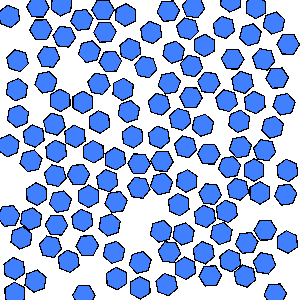

In [3]:
ex_render.render_polygon_frame(system.take_snapshot(all=True), poly_verts)

## Compress the system

Set parameters for the compression. 
* **target_phi** is the target packing fraction. 
* **scale_factor** is the factor by which to scale box length on each step.

Note that this method is prone to get stuck in infinite loops. If scale factor is too small, the scale operation may introduce an overlap that even a maximum trial move displacement cannot remove. When this occurs, the overlap will remain indefinately and the loop will not terminate.

In [4]:
target_phi = 0.95
scale_factor = 0.99

Monitor the compression progress

In [5]:
d = hoomd.dump.gsd("trajectory-compress.gsd", period=1000, group=hoomd.group.all(), overwrite=True)
log1 = hoomd.analyze.log(filename="log-output.log", quantities=['lx', 'ly', 'xy', 'hpmc_overlap_count'], period=10, overwrite=True)

This example performs 2D compression. Expanding it to 3D is left as an exercise to the reader. The print statements are helpful to debug infinite loops in the compression scheme.

In [6]:
N = len(system.particles);
target_area = N*poly_area / target_phi;
current_area = system.box.get_volume();

while target_area < current_area:
    current_area = max(current_area*scale_factor, target_area)
    new_box = system.box.set_volume(current_area);
   
    hoomd.update.box_resize(Lx=new_box.Lx, Ly=new_box.Ly, Lz=new_box.Lz, period=None)
    
    overlaps = mc.count_overlaps();
    print("phi =", (N*poly_area) / (new_box.get_volume()), ": overlaps =", overlaps, end=' ');
    
    # run until all overlaps are removed
    while overlaps > 0:
        hoomd.run(100, quiet=True)
        overlaps = mc.count_overlaps()
        print(overlaps, end=' ');
        sys.stdout.flush();
        
    print();

phi = 0.5260942760942761 : overlaps = 5 0 
phi = 0.531408359691188 : overlaps = 7 0 
phi = 0.5367761209001899 : overlaps = 9 0 
phi = 0.5421981019193837 : overlaps = 4 0 
phi = 0.5476748504236199 : overlaps = 4 0 
phi = 0.5532069196198182 : overlaps = 5 0 
phi = 0.5587948683028465 : overlaps = 2 0 
phi = 0.5644392609119663 : overlaps = 5 0 
phi = 0.5701406675878445 : overlaps = 10 0 
phi = 0.5758996642301463 : overlaps = 8 0 
phi = 0.5817168325557031 : overlaps = 11 0 
phi = 0.587592760157276 : overlaps = 5 0 
phi = 0.5935280405629049 : overlaps = 10 0 
phi = 0.5995232732958635 : overlaps = 7 0 
phi = 0.6055790639352157 : overlaps = 10 0 
phi = 0.6116960241769854 : overlaps = 7 0 
phi = 0.6178747718959451 : overlaps = 5 0 
phi = 0.6241159312080252 : overlaps = 7 0 
phi = 0.6304201325333589 : overlaps = 6 0 
phi = 0.6367880126599584 : overlaps = 9 0 
phi = 0.6432202148080388 : overlaps = 10 0 
phi = 0.6497173886949889 : overlaps = 13 0 
phi = 0.6562801906009988 : overlaps = 6 0 
phi = 0

Size: 550.6611328125 KiB


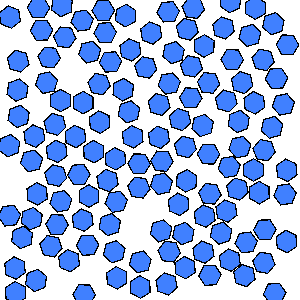

In [7]:
ex_render.display_movie(lambda x: ex_render.render_polygon_frame(x, poly_verts, Ly=initial_Ly), 'trajectory-compress.gsd')

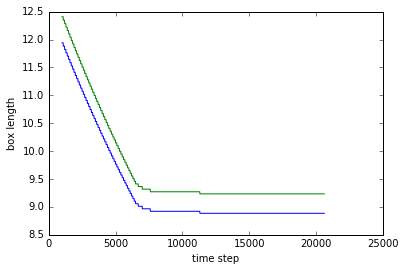

In [8]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True)
pyplot.plot(data[:,0], data[:,1], label='Lx')
pyplot.plot(data[:,0], data[:,2], label='Ly')
pyplot.ylabel('box length')
pyplot.xlabel('time step')

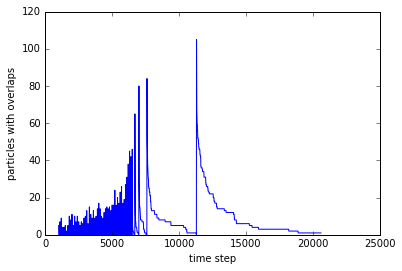

In [9]:
data = numpy.genfromtxt(fname='log-output.log', skip_header=True)
pyplot.plot(data[:,0], data[:,4])
pyplot.ylabel('particles with overlaps')
pyplot.xlabel('time step')